# CS413 Image and Video Analysis -- Coursework

# Sam Moon - 2001779

# Part 2: Spot-the-Difference

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import measure
import scipy.ndimage as morpho
import matplotlib.patches as patches
from skimage.feature import peak_local_max

from google.colab import drive
drive.mount('/content/drive')

data_dir = 'drive/My Drive/Colab Notebooks/data/courseworkdata/data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
def showImages (ims, cmap = None):
  fig = plt.figure(figsize=(20, 20))

  for i in range(len(ims)):
    plt.subplot(1, len(ims), i+1)
    plt.axis('off')
    plt.title("Image " + str(i))
    plt.imshow(ims[i], cmap)

  plt.show()

def boundingBox (comps, label=1):
  xx, yy = np.meshgrid(np.arange(0,comps.shape[1]), np.arange(0,comps.shape[0]))

  where_x = xx[comps==label]
  where_y = yy[comps==label]

  return np.min(where_x), np.min(where_y), np.max(where_x), np.max(where_y)

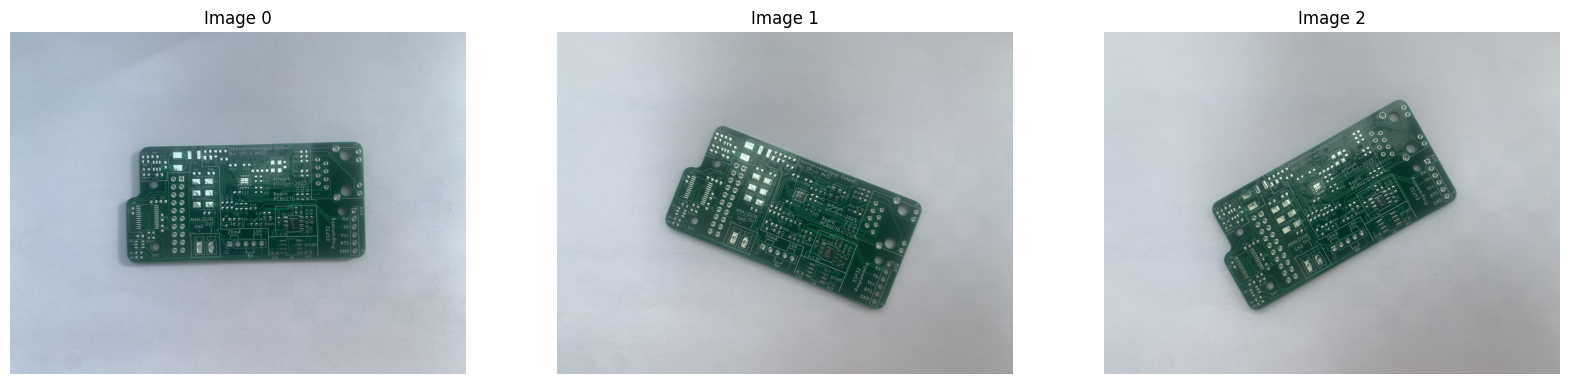

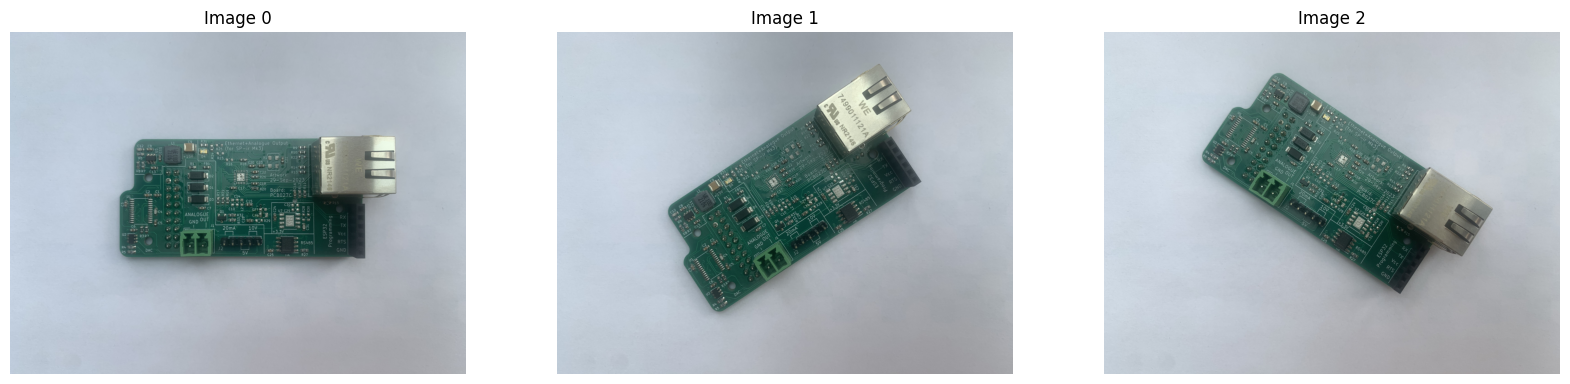

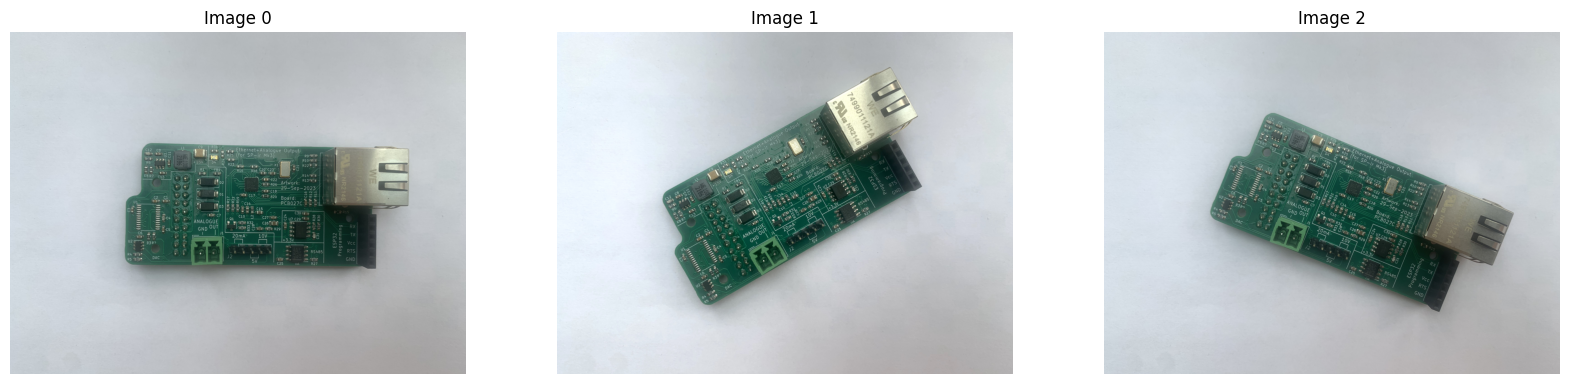

In [39]:
board1 = [plt.imread(data_dir + 'BOARDS/BOARD1-1.jpg')[:,:,:3], plt.imread(data_dir + 'BOARDS/BOARD1-2.jpg')[:,:,:3], plt.imread(data_dir + 'BOARDS/BOARD1-3.jpg')[:,:,:3]]
board2 = [plt.imread(data_dir + 'BOARDS/BOARD2-1.jpg')[:,:,:3], plt.imread(data_dir + 'BOARDS/BOARD2-2.jpg')[:,:,:3], plt.imread(data_dir + 'BOARDS/BOARD2-3.jpg')[:,:,:3]]
board3 = [plt.imread(data_dir + 'BOARDS/BOARD3-1.jpg')[:,:,:3], plt.imread(data_dir + 'BOARDS/BOARD3-2.jpg')[:,:,:3], plt.imread(data_dir + 'BOARDS/BOARD3-3.jpg')[:,:,:3]]

board_im = [board1, board2, board3]

showImages(board1)
showImages(board2)
showImages(board3)

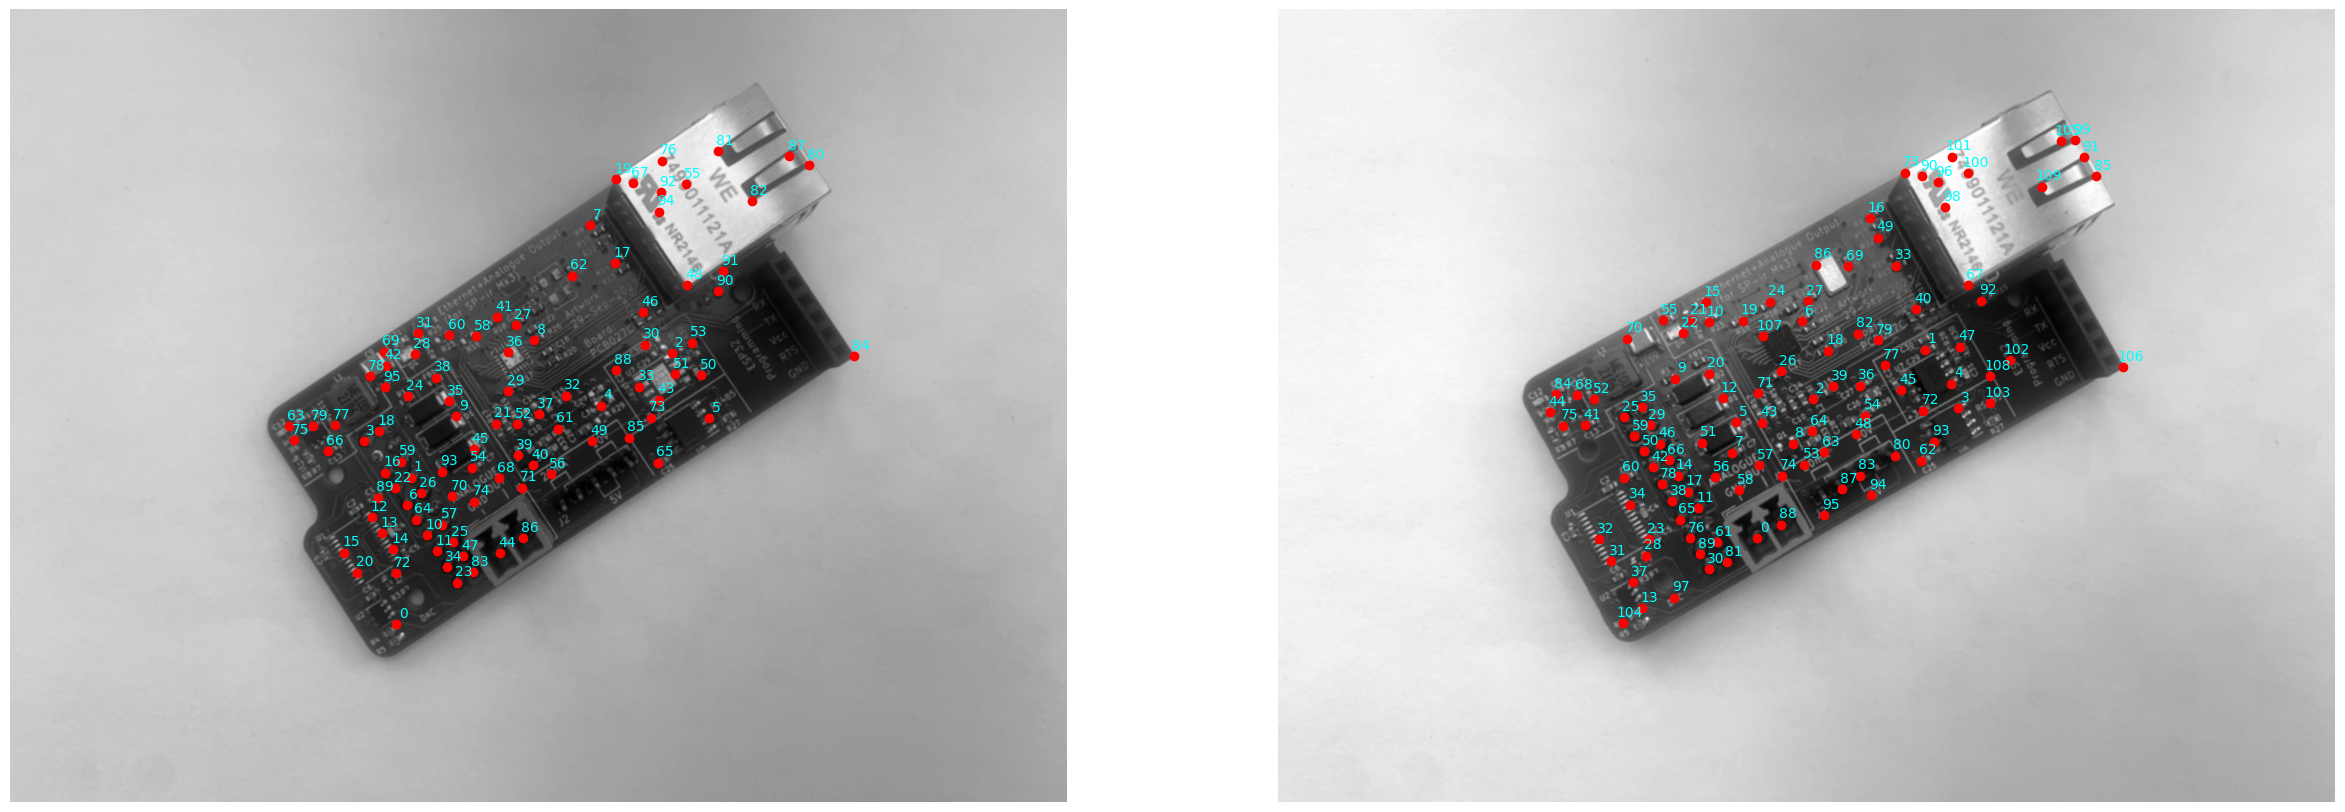

In [40]:
fig = plt.figure(figsize=(30,30))

board_im_corners = []
for i in range(1,3):
  harris = []
  for j in range(1,2):
    board_gray = cv2.cvtColor(cv2.blur(board_im[i][j], (9, 9)), cv2.COLOR_RGB2GRAY)

    board_harris = cv2.cornerHarris(board_gray, 7, 7, 0.06)
    board_corners = np.flip(peak_local_max(board_harris, min_distance=50, threshold_abs=0.1), axis=1)

    plt.subplot(1, 2, i)
    plt.imshow(board_gray, cmap = 'gray')
    plt.axis('off')
    plt.scatter(board_corners[:,0], board_corners[:,1], color='r')
    labels = [str(i) for i in range(0, board_corners.shape[0])]
    k = 0
    for x, y in zip(board_corners[:,0], board_corners[:,1]):
        plt.annotate(labels[k],
                (x, y),
                textcoords="offset points",
                xytext=(5,5),
                ha='center',
                color=(0,1,1))
        k += 1

    harris.append(board_corners)
  board_im_corners.append(harris)
plt.show()

In [41]:
matches = [(84, 106), (0, 13), (72, 28), (44, 0), (86, 88), (23, 30), (3, 25), (75, 44), (28, 22), (41, 24), (19, 73), (80, 85), (65, 62)]
board2_indices = [matches[k][0] for k in range(len(matches))]
board3_indices = [matches[k][1] for k in range(len(matches))]

board2_corners = board_im_corners[0][0]
board3_corners = board_im_corners[1][0]

In [42]:
src_pts = board2_corners[board2_indices]
dst_pts = board3_corners[board3_indices]

xs = src_pts[:,0]
ys = src_pts[:,1]
xd = dst_pts[:,0]
yd = dst_pts[:,1]

n = len(xs)
A = np.empty((2*n,9))

for i in range(0,n):
    A[2*i,:]= [ xs[i], ys[i], 1, 0, 0,  0, -xd[i]*xs[i], -xd[i]*ys[i], -xd[i] ]
    A[2*i+1,:] = [ 0, 0,  0, xs[i], ys[i], 1, -yd[i]*xs[i], -yd[i]*ys[i], -yd[i] ]

S = np.matmul(A.T, A)
eig_values, eig_vectors = np.linalg.eig(S)
sort_indices = np.argsort(eig_values)
m = eig_vectors[:,sort_indices[0]]

H2 = m.reshape(3,3)
H2 /= H2[2,2]

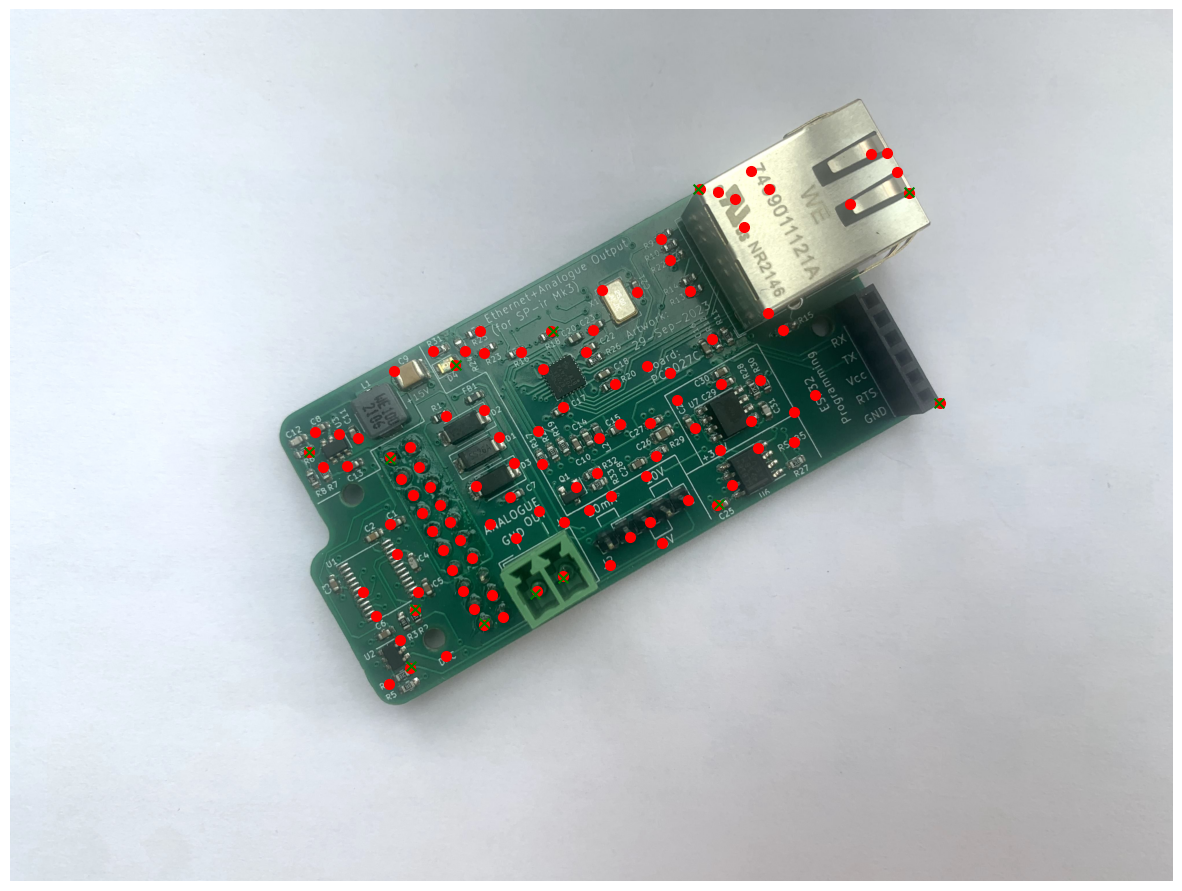

In [43]:
H, mask = cv2.findHomography(board2_corners[board2_indices], board3_corners[board3_indices]);

board2_corners_p = board2_corners[board2_indices].reshape(-1,1,2)
board2_transformed_p = cv2.perspectiveTransform(board2_corners_p.astype('float'),  H)
board2_transformed = board2_transformed_p.reshape(board2_corners[board2_indices].shape[0], 2)

fig = plt.figure(figsize=(15,15))
plt.imshow(board_im[2][1])
plt.axis('off')
plt.scatter(board3_corners[:,0], board3_corners[:,1], color='r', s=49)
plt.scatter(board2_transformed[:,0], board2_transformed[:,1], color='g', marker='x', s=49)

plt.show()

In [44]:
src = cv2.blur(board_im[1][1], (11, 11))
dst = cv2.blur(board_im[2][1], (11, 11))

dst_2 = cv2.warpPerspective(src, H, (dst.shape[1], dst.shape[0]))

fig = plt.figure(figsize=(30,30))
plt.title('Warped Board3 overlayed on Board2')
plt.imshow(cv2.cvtColor(dst_2, cv2.COLOR_BGR2GRAY), cmap='jet', alpha=1)
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY), cmap='gray', alpha=0.5)
plt.axis('off')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

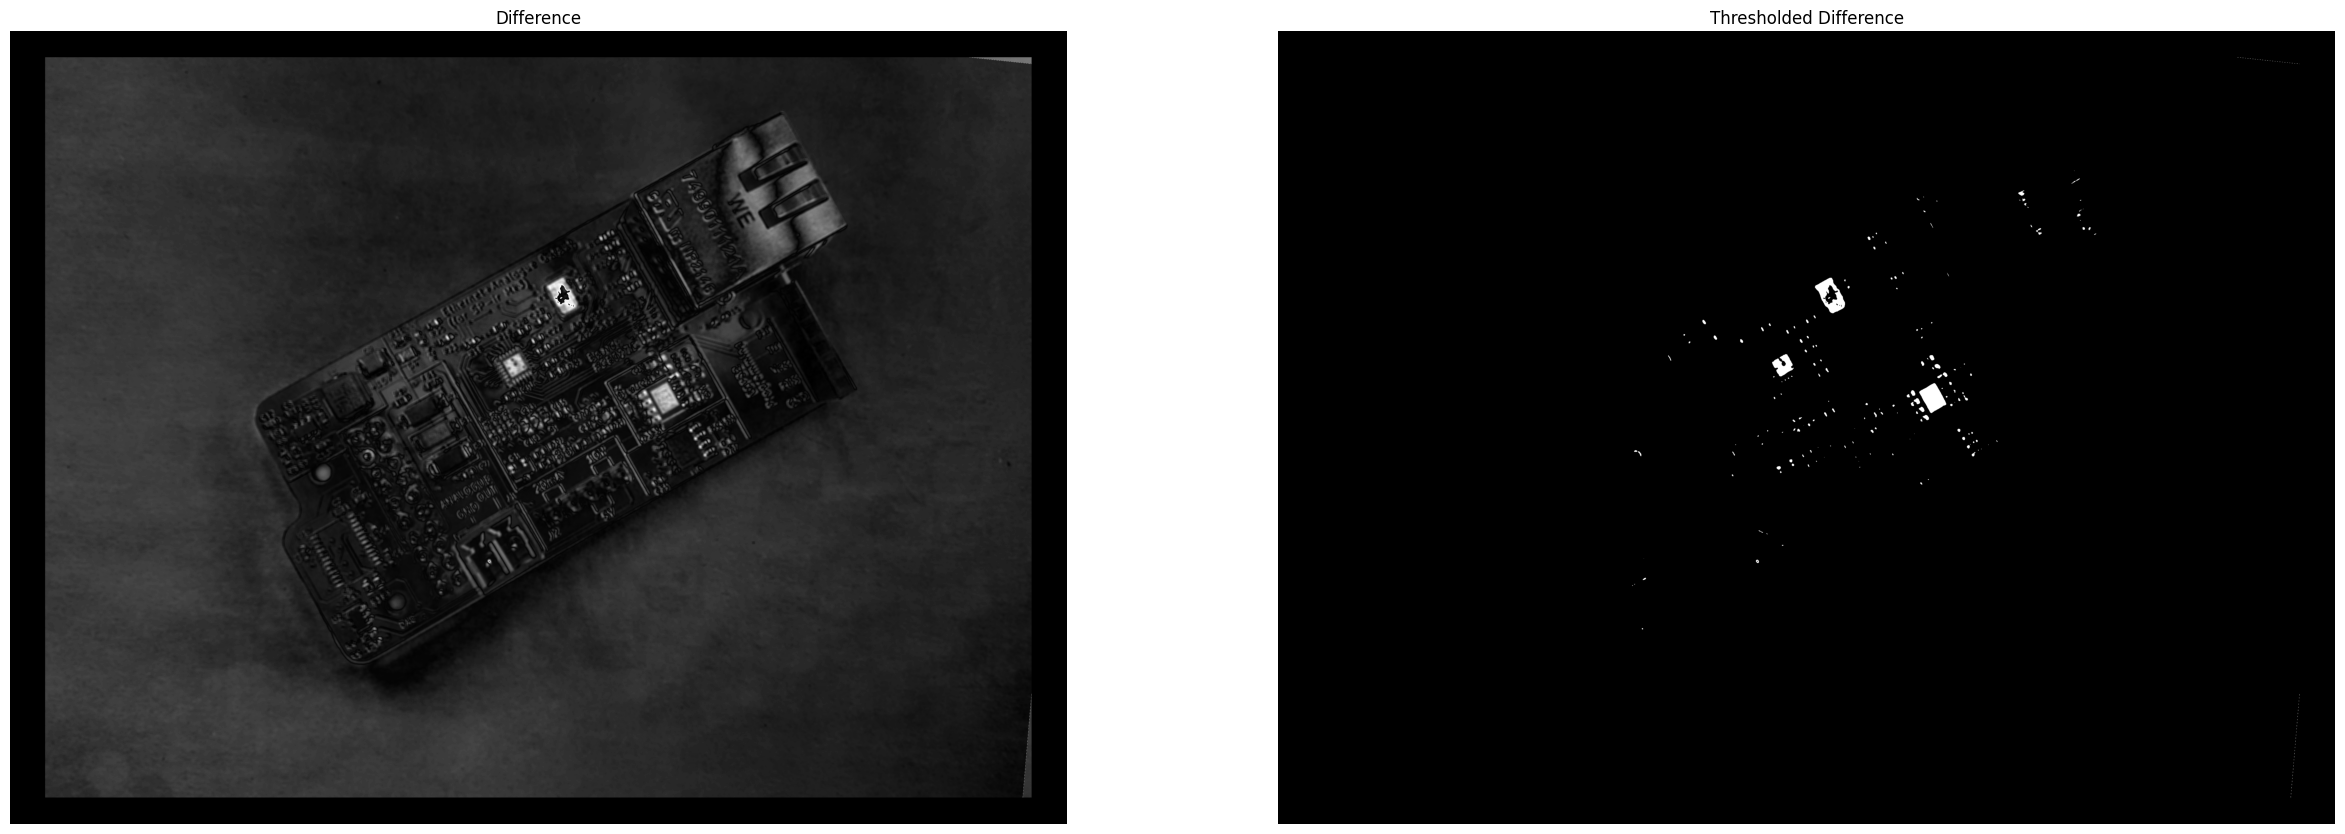

In [45]:
diff = np.sqrt(np.sum(np.square(dst.astype("int32") - dst_2.astype("int32")), axis=2)).astype("uint8")
diff[:diff.shape[0]//30, :] = 0
diff[-diff.shape[0]//30:, :] = 0
diff[:, :diff.shape[1]//30] = 0
diff[:, -diff.shape[1]//30:] = 0

fig = plt.figure(figsize=(30, 30))

plt.subplot(1, 2, 1)
plt.title("Difference")
plt.imshow(diff, 'gray')
plt.axis('off')

thresh = np.zeros(diff.shape)
thresh[diff>0.5*np.max(diff)] = 1

edt = morpho.distance_transform_edt(thresh)
thresh[edt < 0.005*np.max(edt)] = 0

plt.subplot(1, 2, 2)
plt.title("Thresholded Difference")
plt.imshow(thresh, 'gray')
plt.axis('off')

plt.show()

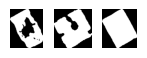

In [46]:
thresh_comp = measure.label(thresh, background = 0)

bounds = []
components = []

unique = np.unique(thresh_comp)

min_size = np.min(thresh.shape) * 0.01
max_size = np.max(thresh.shape) * 0.3

fig = plt.figure(figsize=(30, 30))
k = 1
for l in unique:
    bb = boundingBox(thresh_comp, label=l)

    if (bb[3] - bb[1] > min_size and bb[3] - bb[1] < max_size and bb[2] - bb[0] > min_size and bb[2] - bb[0] < max_size):
      one_comp = np.zeros(thresh_comp.shape, dtype='uint8')
      one_comp[thresh_comp==l] = 1

      one_comp = one_comp[bb[1]:bb[3],bb[0]:bb[2]]

      bounds.append(bb)
      components.append(one_comp)

      plt.subplot(50, 50, k)
      plt.imshow(one_comp, cmap='gray')
      plt.axis('off')

      k += 1
plt.show()

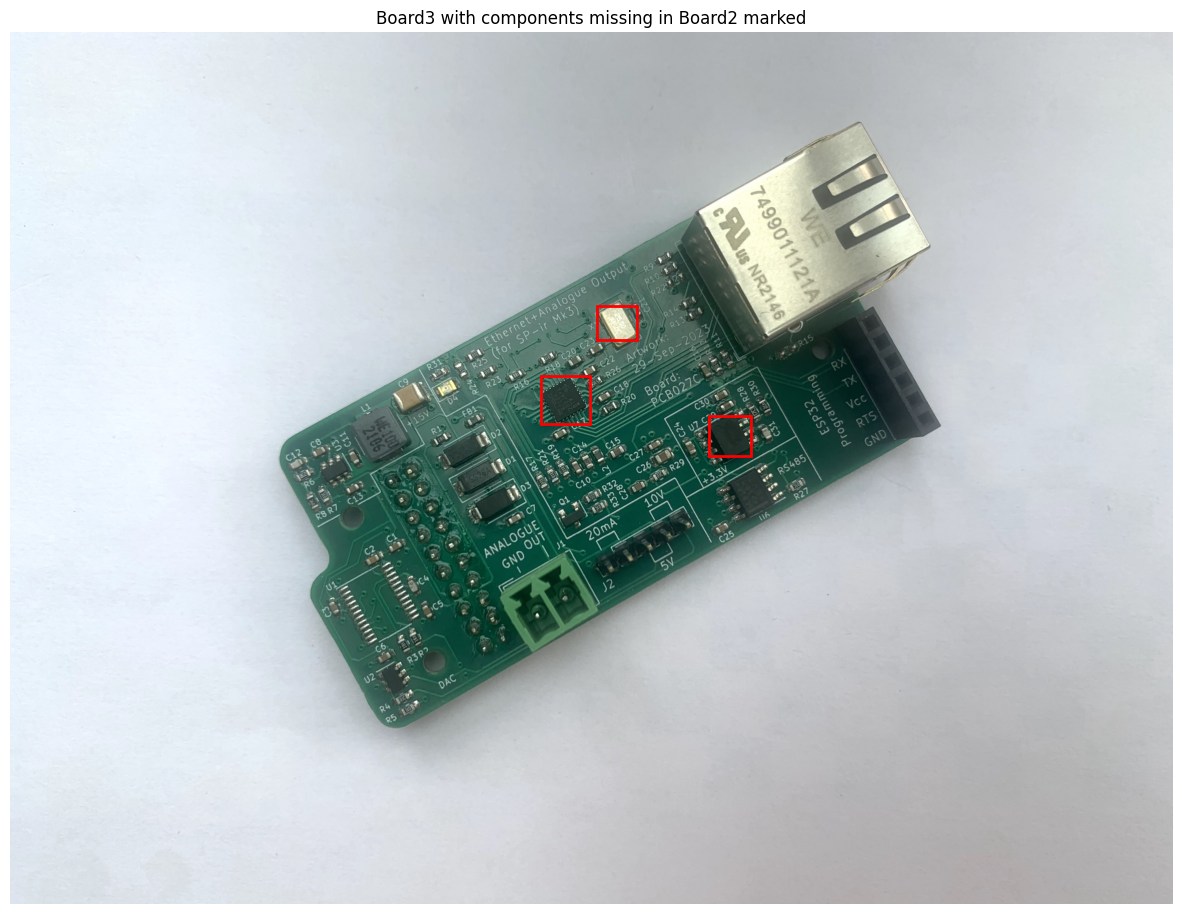

In [47]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)

plt.title('Board3 with components missing in Board2 marked')
plt.imshow(board_im[2][1])
plt.axis('off')

for bound in bounds:
  ax.add_patch(patches.Rectangle((bound[2]-125, bound[3]-125), 250+(bound[0] - bound[2]), 250+(bound[1] - bound[3]), linewidth = 2, edgecolor='r', fill = False))

plt.show()